In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Our Helper Functions
from helper import *

Using TensorFlow backend.


# Read Dataset

In [2]:
lines = pd.read_pickle("./data/02_bin/01_lines.bin")

In [3]:
lines.head()

,user,sess_id,line_id,line_text
0,USER1+0,USER0->0,0,whoami
1,USER1+0,USER0->0,1,pwd
2,USER1+0,USER0->0,2,ls
3,USER1+0,USER0->0,3,dir
4,USER1+0,USER0->0,4,vi


# Tokenize Dataset

In [4]:
corpus = lines.line_text
tokenizer = Tokenizer(lower=False, split=' ', filters="")
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index)+1
encoded = tokenizer.texts_to_sequences(corpus)

In [5]:
corpus.to_frame().assign(encoded=encoded).head(10)

,line_text,encoded
0,whoami,[485]
1,pwd,[42]
2,ls,[3]
3,dir,[22]
4,vi,[6]
5,source <1>,"[100, 1]"
6,source <1>,"[100, 1]"
7,exit,[13]
8,whereis <1>,"[293, 1]"
9,mkdir <1>,"[74, 1]"


# Model 1: One-Word-In, One-Word-Out Sequences

In [6]:
corpus.iloc[60:65].to_frame().assign(
    model_inputs = [ tokenizer.sequences_to_texts(segment_and_pad(t)) for t in encoded[60:65]],
    model_inputs_as_nums = [ segment_and_pad(t) for t in encoded[60:65]]
)

,line_text,model_inputs,model_inputs_as_nums
60,inger <1>,[inger <1>],"[[1177, 1]]"
61,r -l <2>,"[r -l, -l <2>]","[[79, 15], [15, 4]]"
62,exit,[exit],"[[13, 0]]"
63,elm,[elm],"[[7, 0]]"
64,elm,[elm],"[[7, 0]]"


In [7]:
sequences = segment_and_pad_all(encoded, size=2)

Segmenting and padding...: 100%|██████████| 145687/145687 [03:41<00:00, 658.52it/s] 


In [8]:
sequences = np.array(sequences)s

(162049, 2)

In [9]:
X = sequences[:,0]
y = to_categorical(sequences[:,1], num_classes=vocab_size)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.50, 
    random_state=2019
)

In [10]:
model1 = Sequential([
    Embedding(vocab_size, 100, input_length=1),
    LSTM(100, dropout = 0.2),
    Dense(vocab_size, activation='softmax')
])
model1.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

history = model1.fit(X_train, y_train, validation_split=0.25, epochs=10, batch_size=16, verbose=1)

Train on 60768 samples, validate on 20256 samples
Epoch 1/10
60768/60768 [==============================] - 43s 709us/step - loss: 1.2573 - acc: 0.7394 - val_loss: 0.8739 - val_acc: 0.7904
Epoch 2/10
60768/60768 [==============================] - 40s 663us/step - loss: 0.7753 - acc: 0.8056 - val_loss: 0.7496 - val_acc: 0.8059
Epoch 3/10
60768/60768 [==============================] - 41s 682us/step - loss: 0.6865 - acc: 0.8145 - val_loss: 0.6966 - val_acc: 0.8098
Epoch 4/10
60768/60768 [==============================] - 46s 758us/step - loss: 0.6511 - acc: 0.8172 - val_loss: 0.6836 - val_acc: 0.8107
Epoch 5/10
60768/60768 [==============================] - 45s 739us/step - loss: 0.6307 - acc: 0.8188 - val_loss: 0.6712 - val_acc: 0.8090
Epoch 6/10
60768/60768 [==============================] - 41s 680us/step - loss: 0.6177 - acc: 0.8194 - val_loss: 0.6670 - val_acc: 0.8110
Epoch 7/10
60768/60768 [==============================] - 42s 688us/step - loss: 0.6100 - acc: 0.8197 - val_loss: 0.

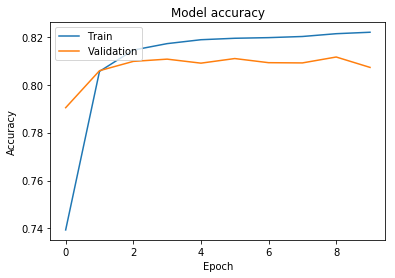

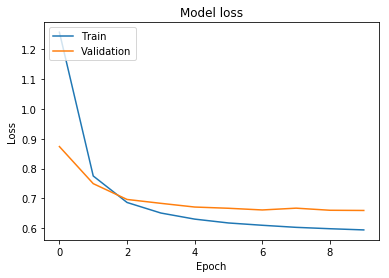

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
y_pred = model1.predict_classes(X_test)
y_truth = y_test.argmax(axis=1)
print(
    f"  Holdout Set Accuracy = {round(accuracy_score(y_truth, y_pred)*100,2)}%"
)

  Holdout Set Accuracy = 80.94%


# Model 2: Padded Lines

In [20]:
corpus.iloc[100:110].to_frame().assign(
    model_inputs_as_nums = [ segment_and_pad(t, size=4, pad_pre=False) for t in encoded[100:110]]
)

,line_text,model_inputs_as_nums
100,finger <1>,"[[0, 0, 18, 1]]"
101,lname <2>,"[[0, 0, 257, 4]]"
102,lname <1> | grep <1>,"[[257, 1, 21, 9], [1, 21, 9, 1]]"
103,finger <1>,"[[0, 0, 18, 1]]"
104,finger <1>,"[[0, 0, 18, 1]]"
105,ping <1>,"[[0, 0, 93, 1]]"
106,finger <1>,"[[0, 0, 18, 1]]"
107,finger <1>,"[[0, 0, 18, 1]]"
108,finger <1>,"[[0, 0, 18, 1]]"
109,date,"[[0, 0, 0, 59]]"


In [18]:
sequences = segment_and_pad_all(encoded, size=4, pad_pre=False)


Segmenting and padding...: 100%|██████████| 145687/145687 [03:27<00:00, 701.59it/s]

In [21]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = to_categorical(sequences[:,-1], num_classes=vocab_size)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.50, 
    random_state=2019
)

In [23]:
model2 = Sequential([
    Embedding(vocab_size, 10, input_length=3),
    LSTM(10, dropout = 0.2),
    Dense(vocab_size, activation='softmax')
])
model2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

history = model2.fit(X_train, y_train, validation_split=0.25, epochs=10, batch_size=16, verbose=1)

Train on 55751 samples, validate on 18584 samples
Epoch 1/10
55751/55751 [==============================] - 18s 321us/step - loss: 2.9174 - acc: 0.4724 - val_loss: 2.6984 - val_acc: 0.4708
Epoch 2/10
55751/55751 [==============================] - 15s 277us/step - loss: 2.5750 - acc: 0.4724 - val_loss: 2.2934 - val_acc: 0.4650
Epoch 3/10
55751/55751 [==============================] - 17s 299us/step - loss: 2.0517 - acc: 0.5916 - val_loss: 1.9543 - val_acc: 0.6241
Epoch 4/10
55751/55751 [==============================] - 17s 310us/step - loss: 1.8483 - acc: 0.6287 - val_loss: 1.8528 - val_acc: 0.6316
Epoch 5/10
55751/55751 [==============================] - 16s 284us/step - loss: 1.7598 - acc: 0.6362 - val_loss: 1.7904 - val_acc: 0.6376
Epoch 6/10
55751/55751 [==============================] - 17s 301us/step - loss: 1.7125 - acc: 0.6390 - val_loss: 1.7553 - val_acc: 0.6406
Epoch 7/10
55751/55751 [==============================] - 15s 263us/step - loss: 1.6843 - acc: 0.6426 - val_loss: 1.

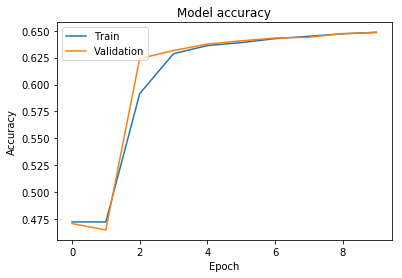

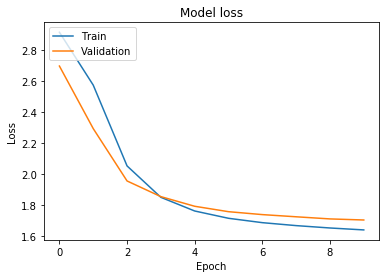

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
y_pred = model2.predict_classes(X_test)
y_truth = y_test.argmax(axis=1)
print(
    f"  Holdout Set Accuracy = {round(accuracy_score(y_truth, y_pred)*100,2)}%"
)

  Holdout Set Accuracy = 64.94%


# Utilization of Results


In [192]:
def predict_next(cmd: str) -> str:
    return tokenizer.sequences_to_texts([
        model1.predict_classes([
            tokenizer.word_index[cmd]
        ])
    ])[0]

from random import sample
def random_cmd_gen(n: int = 3) -> str:
    cur_cmd = sample(tokenizer.word_index.keys(), 1)[0]
    full_cmd = cur_cmd

    for _ in range(n):
        cur_cmd = predict_next(cur_cmd)
        full_cmd += f' {cur_cmd}'
        if cur_cmd == "":
            break

    return full_cmd

In [198]:
for _ in range(20):
    print(random_cmd_gen(3))


xrd <1> & cd
hi 
,pre <1> & cd
dc 
gorkemlik 
lpstat <1> & cd
<GENSYM:26>/qshow <2> | grep
-kl <1> & cd
<GENSYM:1>/hosts <1> & cd
psd 
pw <1> & cd
.. 
makeflat <1> & cd
-n2 <1> & cd
*.m 
<GENSYM:0>/talk <1> & cd
gorkem <1> & cd
dte 
vdiff 
audiotool & cd <1>
